In [1]:
########################## 这个是最终的结果，之前的相关性写错了 ##############
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

In [3]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [4]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

In [5]:
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    P=[]###原始值
    G=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log10(XI)
    yi=np.log10(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
            P.append(XI[mm])
            G.append(YI[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
        
    ###按照sc的值进行排序
    scdic = list(zip(sc,City))
    scSort = sorted( scdic)###残差城市排序
    prodic = list(zip(sc,pro))
    proSort = sorted( prodic)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort,XI,YI)

In [6]:
def getCity(s):
    a=list(s.split('|'))
    return(a[1])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省

In [7]:
###热图
###每一个城市的残差的均值
### 相关性应该是 平方和开方为分母，连×之和为分子
def get_cij(scall,cityname):
    dfscyear = pd.DataFrame(scall, columns=cityname)###将每一年的残差转化为dataframe city*year
    ###求Cij
    Cij=[]
    for i in range(len(cityname)):
        c1=dfscyear[cityname[i]].values###得到城市1的残差
        c1Sum = 0
        for ccc in range(18):
            c1Sum += c1[ccc]**2 ###城市17年间残差平方连加
        lenc1 = math.sqrt(c1Sum)###得到分母
        #absc1=cityAvg[i]
        cij=[]
        for j in range(len(cityname)):
            c2=dfscyear[cityname[j]].values###得到城市2的残差
            addc12=0
            c2Sum = 0
            for c in range(18):
                mul=c1[c]*c2[c]
                addc12=addc12+mul
                c2Sum += c2[c]**2 ###城市17年间残差平方连加
            lenc2 = math.sqrt(c2Sum)###得到分母
            c12=addc12/(lenc1*lenc2)
            cij.append(c12)###两个城市cij
        Cij.append(cij)
    dfCij= pd.DataFrame(Cij)  
    return(dfCij)

In [8]:
#################  1. GMP ##########

In [24]:
########## 
cityM = GuiJI(data,pop,investment,15,'pop','amount')[1]###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据
####查看一些城市2000-2016年的残差分布图
scall_x=[]###保存所有城市2000-2016年的残差
scallM_x=[]
scallT_x=[]
scall_y=[]###保存所有城市2000-2016年的残差
scallM_y=[]
scallT_y=[]
for i in range(18):    
    ### GDP残差
    sami=GuiJI(data,pop,gdp,i,'pop','GDP')
    XG=sami[12]###获取某一年的POP
    YG=sami[13]###获取某一年的AMOUNT
    cityname=sami[1]###城市名

    ###amount
    samiM=GuiJI(data,pop,investment,i,'pop','amount')
    XM=samiM[12]###获取某一年的POP
    YM=samiM[13]###获取某一年的AMOUNT
    citynameM=samiM[1]###城市名

    ###times
    samiT=GuiJI(data,pop,inv_times,i,'pop','times')
#     scT=samiT[5]###获取某一年的残差值
    XT=samiT[12]###获取某一年的POP
    YT=samiT[13]###获取某一年的AMOUNT
    citynameT=samiT[1]###城市名
 
    ### 删选出来含有投资的城市的GDP\TIMES
    X_GDP0=[] ###保存含有投资的城市的GDP
    X_amount0 = [] ###投资金额
    X_times0=[] ###保存旱藕投资的城市的投资次数
    Y_GDP0=[] ###保存含有投资的城市的GDP
    Y_amount0 = [] ###投资金额
    Y_times0=[] ###保存旱藕投资的城市的投资次数
    ### 1 得到GDP的数据
    for c1 in cityM:
        have = 0 ###标志该城市是否存在,0表示不存在
        for c2 in range(len(cityname)):
            if cityname[c2] == c1:
                X_GDP0.append(XG[c2])
                Y_GDP0.append(YG[c2])
#                 sc_GDP0.append(sc[c2])
                have = 1
        if have == 0:
#             sc_GDP0.append(0)
            X_GDP0.append(0)
            Y_GDP0.append(0)
    ### 2 得到投资金额的数据
    for c1 in cityM:
        have1 = 0 ###标值该城市是否存在,0表示不存在
        for c2 in range(len(citynameM)):
            if citynameM[c2] == c1:
                X_amount0.append(XM[c2])
                Y_amount0.append(YM[c2])
                
                have1 = 1
        if have1 == 0:
            X_amount0.append(0)
            Y_amount0.append(0)
    ### 3 得到投资次数的残差数据
    for c1 in cityM:
        have2 = 0
        for c2 in range(len(citynameT)):
            if citynameT[c2] == c1:
                X_times0.append(XT[c2])
                Y_times0.append(YT[c2])
#                 sc_times0.append(scT[c2])

                have2 = 1
        if have2 == 0:
            X_times0.append(0)
            Y_times0.append(0)
    scall_x.append(X_GDP0)
    scallM_x.append(X_amount0)
    scallT_x.append(X_times0)
    scall_y.append(Y_GDP0)
    scallM_y.append(Y_amount0)
    scallT_y.append(Y_times0)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [53]:
############# 归一化处理，查看城市近20年发展 ############
def guiyi_data(datalist,name):
    data = pd.DataFrame(datalist)
    data = dfG.apply(lambda x:x/x.max(),axis=1)
    font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }###设置横纵坐标的字体格式
    year = np.arange(2000,2018)
    plt.xlabel('year',font2)
    plt.ylabel(name+'/max('+name+')',font2)
    plt.tick_params(labelsize=16) #刻度字体大小13
    for i in range(data.shape[1]):
        if np.mean(data[i])>0.2:
            plt.plot(year,data[i],color='red',alpha=0.75)
        elif np.mean(data[i])>0.08:
            plt.plot(year,data[i],color='blue',alpha=0.55)
        else:
            plt.plot(year,data[i],color='orange',alpha=0.35)

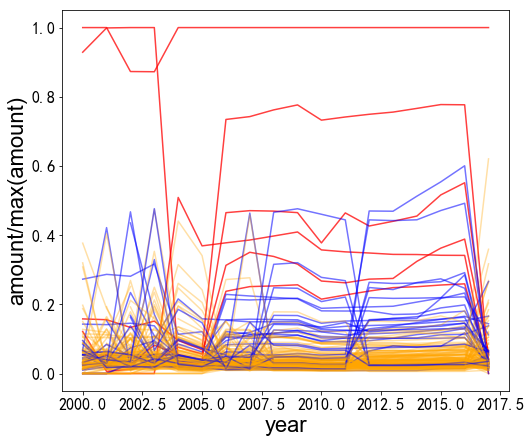

In [54]:
plt.figure(figsize=(8,7))
guiyi_data(scallM_y,'amount')

In [32]:
dfG = pd.DataFrame(scall_x)
dfG.apply(lambda x:x/x.max(),axis=1)

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,1.000000,0.018844,0.000000,NaN,0.053762,0.023300,0.064229,0.010328,0.035770,0.043967,...,0.030697,NaN,0.054252,0.061191,0.066606,0.307884,0.030771,0.031443,0.062118,0.000000
1,1.000000,0.018293,0.000000,NaN,0.053862,0.024390,0.060976,0.012195,0.034553,0.042683,...,0.031504,0.039634,0.039634,0.052846,0.029472,0.027439,0.046748,0.164634,0.030488,0.000000
2,0.872933,0.016536,0.000000,NaN,0.047399,0.040905,0.053960,0.013055,0.033072,0.038294,...,0.043516,0.099217,0.033072,0.028721,0.467363,0.029591,0.029591,0.048738,0.211488,0.000000
3,0.872340,0.015319,0.000000,NaN,0.047595,0.048511,0.053617,0.012766,0.033191,0.037447,...,0.028085,0.011064,0.476596,0.028936,0.066383,0.052766,0.212766,0.059574,0.159149,0.000000
4,1.000000,0.014740,0.508922,0.044520,0.027153,0.083786,0.033359,0.114818,0.034135,0.015516,...,0.440652,0.028704,0.026377,0.059736,0.185415,0.125679,0.040341,0.010861,0.031808,0.000000
5,1.000000,0.010686,0.368954,0.033098,0.014061,0.076490,0.025872,0.084927,0.024747,0.011249,...,0.340832,0.020810,0.019685,0.042182,0.146794,0.097300,0.030371,0.008436,0.023060,0.000000
6,1.000000,0.012561,0.377757,0.033227,0.034654,0.080311,0.111196,0.026616,0.033943,0.115824,...,0.018952,0.049463,0.049915,0.043634,0.013278,0.149299,0.078955,0.018456,0.015542,0.037971
7,1.000000,0.012594,0.385893,0.032905,0.037765,0.077182,0.118929,0.026323,0.032410,0.107595,...,0.051602,0.050940,0.046527,0.037872,0.148314,0.080642,0.030289,0.022168,0.013331,0.007427
8,1.000000,0.012476,0.397467,0.032699,0.038703,0.075924,0.144562,0.027186,0.032106,0.110497,...,0.050676,0.045646,0.141941,0.013106,0.082040,0.029866,0.028383,0.007498,0.037226,0.058503
9,1.000000,0.013824,0.409135,0.032951,0.040280,0.081225,0.145317,0.026711,0.031973,0.101441,...,0.050382,0.045266,0.140825,0.013007,0.080507,0.029620,0.029251,0.007370,0.037807,0.057065


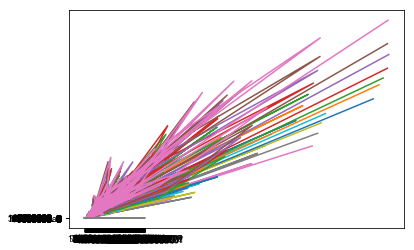

In [13]:
for i in range(len(scall_x)):
    plt.plot(scall_x[i],scall_y[i])

In [14]:
len(scall_x)

18